The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


#  Aprendizado Sequência a Sequência
:label:`sec_seq2seq`

Como vimos em :numref:`sec_machine_translation`,
na tradução automática
tanto a entrada quanto a saída são uma sequência de comprimento variável.
Para resolver este tipo de problema,
nós projetamos uma arquitetura geral de codificador-decodificador
in :numref:`sec_encoder-decoder`.
Nesta secção,
nós vamos
use dois RNNs para projetar
o codificador e o decodificador de
esta arquitetura
e aplicá-lo a *sequência a sequência* de aprendizagem
para tradução automática
:cite:`Sutskever.Vinyals.Le.2014, Cho.Van-Merrienboer.Gulcehre.ea.2014`.

Seguindo o princípio de design
da arquitetura codificador-decodificador,
o codificador RNN pode
pega uma sequência de comprimento variável como entrada e a transforma em um estado oculto de forma fixa.
Em outras palavras,
informação da sequência de entrada (fonte)
é *codificado* no estado oculto do codificador RNN.
Para gerar o token de sequência de saída por token,
um decodificador RNN separado
pode prever o próximo token com base em
quais tokens foram vistos (como na modelagem de linguagem) ou gerados,
junto com as informações codificadas da sequência de entrada.
:numref:`fig_seq2seq` ilustra
como usar dois RNNs
para aprendizagem de sequência para sequência
na tradução automática.


![Aprendizado sequência a sequência com um codificador RNN e um decodificador RNN.](http://d2l.ai/_images/seq2seq.svg)
:label:`fig_seq2seq`

Em :numref:`fig_seq2seq`,
o especial "&lt;bos&gt;" símbolo
marca o fim da sequência.
O modelo pode parar de fazer previsões
uma vez que este token é gerado.
Na etapa de tempo inicial do decodificador RNN,
existem duas decisões de design especiais.
Primeiro, o início de sequência especial "&lt;bos&gt;" token é uma entrada.
Segundo,
o estado final oculto do codificador RNN é usado
para iniciar o estado oculto do decodificador.
Em designs como :cite:`Sutskever.Vinyals.Le.2014`,
isto é exatamente
como as informações da sequência de entrada codificada
é alimentado no decodificador para gerar a sequência de saída (destino).
Em alguns outros designs, como :cite:`Cho.Van-Merrienboer.Gulcehre.ea.2014`,
o estado oculto final do codificador
também é alimentado no decodificador como
parte das entradas
em cada etapa de tempo, conforme mostrado em :numref:`fig_seq2seq`.
Semelhante ao treinamento de modelos de linguagem em
:numref:`sec_language_model`,
podemos permitir que os rótulos sejam a sequência de saída original,
deslocado por um token:
"&lt;bos&gt;", "Ils", "regardent", "." $\rightarrow$
"Ils", "regardent", ".", "&lt;eos&gt;".


Na sequência,
vamos explicar o design de :numref:`fig_seq2seq`
em maiores detalhes.
Vamos treinar este modelo para tradução automática
no conjunto de dados inglês-francês, conforme apresentado em
:numref:`sec_machine_translation`.


In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

## Encoder

Tecnicamente falando,
o codificador transforma uma sequência de entrada de comprimento variável em um formato fixo *variável de contexto* $\ mathbf{c}$ e codifica as informações da sequência de entrada nesta variável de contexto.
Conforme descrito em :numref:`fig_seq2seq`,
podemos usar um RNN para projetar o codificador.

Vamos considerar um exemplo de sequência (tamanho do lote: 1).
Suponha que
a sequência de entrada é $x_1, \ldots, x_T$, de modo que $x_t$ é o token $t^{\mathrm{th}}$ na sequência de texto de entrada.
No passo de tempo $t$, o RNN transforma
o vetor de característica de entrada $\mathbf{x}_t$ para $x_t$
e o estado oculto $\mathbf{h} _{t-1}$ da etapa de tempo anterior
no estado oculto atual $\mathbf{h}_t$.
Podemos usar a função $f$ para expressar a transformação da camada recorrente do RNN:

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$

Em geral,
o codificador transforma os estados ocultos em
todos os passos do tempo
na variável de contexto por meio de uma função personalizada $q$:

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

Por exemplo, ao escolher $q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$ como em :numref:`fig_seq2seq`,
a variável de contexto é apenas o estado oculto $\mathbf{h}_T$
da sequência de entrada na etapa de tempo final.

Até agora, usamos um RNN unidirecional
para projetar o codificador,
Onde
um estado oculto depende apenas de
a subsequência de entrada na e antes da etapa de tempo do estado oculto.
Também podemos construir codificadores usando RNNs bidirecionais. Neste caso, um estado oculto depende de
a subsequência antes e depois da etapa de tempo (incluindo a entrada na etapa de tempo atual), que codifica as informações de toda a sequência.

Agora, vamos implementar o codificador RNN.
Observe que usamos uma *camada de incorporação*
para obter o vetor de recurso para cada token na sequência de entrada.
O peso
de uma camada de incorporação
é uma matriz
cujo número de linhas é igual ao tamanho do vocabulário de entrada (`vocab_size`)
e o número de colunas é igual à dimensão do vetor de recursos (`embed_size`).
Para qualquer índice de token de entrada $i$,
a camada de incorporação
busca a $i^{\mathrm{th}}$ linha (começando em 0) da matriz de peso
para retornar seu vetor de recurso.
Além do mais,
aqui, escolhemos um GRU multicamadas para
implementar o codificador.


In [2]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

As variáveis retornadas de camadas recorrentes
foram explicados em :numref:`sec_rnn-concise`.
Vamos ainda usar um exemplo concreto
para ilustrar a implementação do codificador acima.
Abaixo de
nós instanciamos um codificador GRU de duas camadas
cujo número de unidades ocultas é 16.
Dado
um minibatch de entradas de sequência `X`
(tamanho do lote: 4, número de etapas de tempo: 7),
os estados ocultos da última camada
em todas as etapas do tempo
(retorno de `saída` pelas camadas recorrentes do codificador)
são um tensor
de forma
(número de etapas de tempo, tamanho do lote, número de unidades ocultas).


In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

Uma vez que um GRU é empregado aqui,
a forma dos estados ocultos multicamadas
na etapa final do tempo
é
(número de camadas ocultas, tamanho do lote, número de unidades ocultas).
Se um LSTM for usado,
as informações da célula de memória também estarão contidas em `estado`.


In [4]:
state.shape

torch.Size([2, 4, 16])

## Decoder
:label:`sec_seq2seq_decoder`

Como acabamos de mencionar,
a variável de contexto $\mathbf{c}$ da saída do codificador codifica toda a sequência de entrada $x_1, \ldots, x_T$. Dada a sequência de saída $y_1, y_2, \ldots, y_{T'}$ do conjunto de dados de treinamento,
para cada passo de tempo $t'$
(o símbolo difere da etapa de tempo $t$ das sequências de entrada ou codificadores),
a probabilidade de saída do decodificador $y_{t'}$
é condicional
na subsequência de saída anterior
$y_1, \ldots, y_{t'-1}$ e
a variável de contexto $\mathbf{c}$, i.e., $P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$.

Para modelar essa probabilidade condicional em sequências,
podemos usar outro RNN como decodificador.
A qualquer momento, passo $t^\prime$ na sequência de saída,
o RNN pega a saída $y_{t^\prime-1}$ da etapa de tempo anterior
e a variável de contexto $\mathbf{c}$ como sua entrada,
então se transforma
eles e
o estado oculto anterior $\mathbf{s}_{t^\prime-1}$
no
estado oculto $\mathbf{s}_{t^\prime}$ no intervalo de tempo atual.
Como resultado, podemos usar uma função $g$ para expressar a transformação da camada oculta do decodificador:

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$
:eqlabel:`eq_seq2seq_s_t`

Depois de obter o estado oculto do decodificador,
podemos usar uma camada de saída e a operação softmax para calcular a distribuição de probabilidade condicional
$P(y_{t^\prime} \mid y_1, \ldots, y_{t^\prime-1}, \mathbf{c})$ para a saída na etapa de tempo $t^\prime$.

Seguindo :numref:`fig_seq2seq`,
ao implementar o decodificador da seguinte forma,
usamos diretamente o estado oculto na etapa de tempo final
do codificador
para inicializar o estado oculto do decodificador.
Isso requer que o codificador RNN e o decodificador RNN tenham o mesmo número de camadas e unidades ocultas.
Para incorporar ainda mais as informações da sequência de entrada codificada,
a variável de contexto é concatenada
com a entrada do decodificador em todas as etapas de tempo.
Para prever a distribuição de probabilidade do token de saída,
uma camada totalmente conectada é usada para transformar
o estado oculto na camada final do decodificador RNN.


In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

Para ilustrar o decodificador implementado,
abaixo, nós o instanciamos com os mesmos hiperparâmetros do codificador mencionado.
Como podemos ver, a forma de saída do decodificador torna-se (tamanho do lote, número de etapas de tempo, tamanho do vocabulário),
onde a última dimensão do tensor armazena a distribuição de token prevista.


In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

Para resumir,
as camadas no modelo de codificador-decodificador RNN acima são ilustradas em :numref:`fig_seq2seq_details`.

![Camadas em um modelo de codificador-decodificador RNN.](../img/seq2seq-details.svg)
:label:`fig_seq2seq_details`

## Função de Perdas

Em cada etapa de tempo, o decodificador
prevê uma distribuição de probabilidade para os tokens de saída.
Semelhante à modelagem de linguagem,
podemos aplicar softmax para obter a distribuição
e calcular a perda de entropia cruzada para otimização.
Lembre-se de :numref:`sec_machine_translation`
que os tokens de preenchimento especiais
são anexados ao final das sequências
então sequências de comprimentos variados
pode ser carregado de forma eficiente
em minibatches da mesma forma.
Contudo,
previsão de tokens de preenchimento
devem ser excluídos dos cálculos de perdas.

Para este fim,
podemos usar o seguinte
função `sequence_mask`
para mascarar entradas irrelevantes com valores zero
então mais tarde
multiplicação de qualquer previsão irrelevante
com zero igual a zero.
Por exemplo,
se o comprimento válido de duas sequências
excluindo tokens de preenchimento
são um e dois, respectivamente,
as entradas restantes após
o primeiro
e as duas primeiras entradas são zeradas.


In [7]:
#@save
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

Também podemos mascarar todas as entradas do último
alguns eixos.
Se quiser, você pode até especificar
para substituir essas entradas por um valor diferente de zero.


In [8]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

Agora podemos estender a perda de entropia cruzada softmax
para permitir o mascaramento de previsões irrelevantes.
Inicialmente,
máscaras para todos os tokens previstos são definidas como um.
Uma vez que o comprimento válido é fornecido,
a máscara correspondente a qualquer token de preenchimento
será zerado.
No fim,
a perda de todos os tokens
será multiplicado pela máscara para filtrar
previsões irrelevantes de tokens de preenchimento na perda.


In [9]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

Para uma verificação de sanidade, podemos criar três sequências idênticas.
Então nós podemos
especificar que os comprimentos válidos dessas sequências
são 4, 2 e 0, respectivamente.
Como resultado,
a perda da primeira sequência
deve ser duas vezes maior que o da segunda sequência,
enquanto a terceira sequência deve ter uma perda zero.


In [10]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## Treinamento
:label:`sec_seq2seq_training`

No ciclo de treinamento a seguir,
nós concatenamos o token especial de início de sequência
e a sequência de saída original excluindo o token final como
a entrada para o decodificador, conforme mostrado em :numref:`fig_seq2seq`.
Isso é chamado de *aprendizado forçado* porque
a sequência de saída original (rótulos de token) é alimentada no decodificador.
Alternativamente,
também poderíamos alimentar o token *predito*
da etapa de tempo anterior
como a entrada atual para o decodificador.


In [11]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

Agora podemos criar e treinar um modelo de codificador-decodificador RNN
para aprendizado de sequência para sequência no conjunto de dados de tradução automática.


loss 0.019, 10054.7 tokens/sec on cuda:0


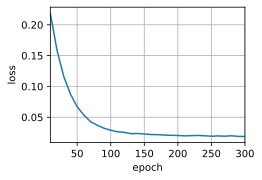

In [12]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## Predição

Para prever a sequência de saída
token por token,
em cada etapa de tempo do decodificador
o token previsto do anterior
intervalo de tempo é alimentado no decodificador como uma entrada.
Semelhante ao treinamento,
na etapa de tempo inicial
o token de início de sequência ("&lt;eos&gt;")
é alimentado no decodificador.
Este processo de previsão
é ilustrado em :numref:`fig_seq2seq_predict`.
Quando o token de fim de sequência ("&lt;eos&gt;") é previsto,
a previsão da sequência de saída está completa.


![Predicting the output sequence token by token using an RNN encoder-decoder.](../img/seq2seq-predict.svg)
:label:`fig_seq2seq_predict`

Vamos apresentar diferentes
estratégias para geração de sequência em
:numref:`sec_beam-search`.


In [13]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## Avaliação de Sequências Preditas

Podemos avaliar uma sequência prevista
comparando-o com o
sequência de rótulos (a verdade fundamental).
BLEU (Understudy de Avaliação Bilíngue),
embora originalmente proposto para avaliação
resultados da tradução automática :cite:`Papineni.Roukos.Ward.ea.2002`,
tem sido amplamente utilizado na medição
a qualidade das sequências de saída para diferentes aplicações.
Em princípio, para quaisquer $n$-gramas na sequência prevista,
BLEU avalia se este $n$-grams aparece
na sequência do rótulo.

Denotado por $p_n$
a precisão de $n$-grams,
qual é
a proporção de
o número de $n$-grams correspondentes em
as sequências preditas e rotuladas
para
o número de $n$-gramas na sequência prevista.
Explicar,
dada uma sequência de rótulo $A$, $B$, $C$, $D$, $E$, $F$,
e uma sequência prevista $A$, $B$, $B$, $C$, $D$,
temos $p_1 = 4/5$,  $p_2 = 3/4$, $p_3 = 1/3$, e $p_4 = 0$.
Além do mais,
deixe $\mathrm{len}_{\text{label}}$ e $\mathrm{len}_{\text{pred}}$
ser
os números de tokens na sequência do rótulo e na sequência prevista, respectivamente.
Então, BLEU é definido como

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

onde $k$ são os $n$-gramas mais longos para correspondência.

Com base na definição de BLEU em :eqref:`eq_bleu`,
sempre que a sequência prevista for igual à sequência do rótulo, BLEU será 1.
Além disso,
já que combinar $n$-gramas mais longos é mais difícil,
BLEU atribui um peso maior
para uma precisão maior de $n$-gram.
Especificamente, quando $p_n$ é corrigido,
$p_n^{1/2^n}$ aumenta à medida que $n$ cresce (o artigo original usa $p_n^{1/n}$).
Além disso,
Desde a
predição de sequências mais curtas
tende a obter um valor maior de $p_n$,
o coeficiente antes do termo de multiplicação em :eqref:`eq_bleu`
penaliza sequências preditas mais curtas.
Por exemplo, quando $k=2$,
dada a sequência de rótulo $A$, $B$, $C$, $D$, $E$, $F$ e a sequência prevista $A$, $B$,
embora $p_1 = p_2 = 1$, o fator de penalidade $\exp(1-6/2) \approx 0.14$ reduz o BLEU.

Implementamos a medida BLEU da seguinte forma.


In [14]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

No fim,
usamos o codificador-decodificador RNN treinado
traduzir algumas frases em inglês para o francês
e calcular o BLEU dos resultados.


In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est paresseux ., bleu 0.658
i'm home . => je suis chez moi en pas question ., bleu 0.640


## Sumário

* Seguindo o projeto da arquitetura do codificador-decodificador, podemos usar dois RNNs para projetar um modelo para o aprendizado de sequência para sequência.
* Ao implementar o codificador e o decodificador, podemos usar RNNs multicamadas.
* Podemos usar máscaras para filtrar cálculos irrelevantes, como ao calcular a perda.
* No treinamento de codificador-decodificador, a abordagem de força do professor alimenta as sequências de saída originais (em contraste com as previsões) para o decodificador.
* BLEU é uma medida popular para avaliar sequências de saída combinando $n$-gramas entre a sequência prevista e a sequência de rótulo.


## Exercícios

1. Você pode ajustar os hiperparâmetros para melhorar os resultados da tradução?
1. Repita o experimento sem usar máscaras no cálculo da perda. Que resultados você observa? Por quê?
1. Se o codificador e o decodificador diferem no número de camadas ou no número de unidades ocultas, como podemos inicializar o estado oculto do decodificador?
1. No treinamento, substitua o forçamento do professor com a alimentação da previsão da etapa de tempo anterior no decodificador. Como isso influencia o desempenho?
1. Execute novamente o experimento substituindo GRU por LSTM.
1. Existem outras maneiras de projetar a camada de saída do decodificador?


[Discussão](https://discuss.d2l.ai/t/1062)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTIwMzI0NzI0NzEsLTE2MDIyNTgzMDksLT
IzNDA1NDE2M119
-->
